<a href="https://colab.research.google.com/github/rajlm10/D2L-Torch/blob/main/D2L_DogBreeds_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers datasets d2l -q

     |████████████████████████████████| 4.2 MB 14.4 MB/s 
     |████████████████████████████████| 346 kB 87.7 MB/s 
     |████████████████████████████████| 82 kB 779 kB/s 
     |████████████████████████████████| 86 kB 5.6 MB/s 
     |████████████████████████████████| 596 kB 81.3 MB/s 
     |████████████████████████████████| 6.6 MB 23.2 MB/s 
     |████████████████████████████████| 212 kB 87.9 MB/s 
     |████████████████████████████████| 86 kB 6.0 MB/s 
     |████████████████████████████████| 140 kB 102.3 MB/s 
     |████████████████████████████████| 1.1 MB 69.5 MB/s 
     |████████████████████████████████| 127 kB 70.0 MB/s 
     |████████████████████████████████| 9.9 MB 65.4 MB/s 
     |████████████████████████████████| 15.7 MB 68.0 MB/s 
     |████████████████████████████████| 61 kB 8.9 MB/s 
     |████████████████████████████████| 11.2 MB 57.9 MB/s 
     |████████████████████████████████| 930 kB 61.4 MB/s 
     |████████████████████████████████| 271 kB 93.4 MB/s 
     |█████████████

In [ ]:
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l
import pandas as pd
import collections
import math
import shutil
from datasets import load_dataset,load_metric
from collections import Counter
from transformers import DeiTFeatureExtractor,DeiTForImageClassification,AdamW,get_scheduler,pipeline
from torch.utils.data import DataLoader
from tqdm.auto import tqdm



#Data Manipulation

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/ 
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!mkdir data

In [ ]:
!kaggle competitions download -c dog-breed-identification -p ./data 

 99% 686M/691M [00:10<00:00, 94.3MB/s]
100% 691M/691M [00:10<00:00, 70.1MB/s]


In [ ]:
!unzip /content/data/dog-breed-identification.zip -d ./data

In [ ]:
pd.read_csv('/content/data/labels.csv').head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
data_dir='./data'

def read_csv_labels(fname):
  """Read `fname` to return a filename to label dictionary.""" 
  with open(fname, 'r') as f:
    # Skip the file header line (column name)
    lines = f.readlines()[1:]
  
  tokens = [l.rstrip().split(',') for l in lines]
  return dict(((name, label) for name, label in tokens))

def copyfile(filename, target_dir):
  """Copy a file into a target directory.""" 
  os.makedirs(target_dir, exist_ok=True) 
  shutil.copy(filename, target_dir)

def reorg_train_valid(data_dir, labels, valid_ratio):
  """Split the validation set out of the original training set."""
  # The number of examples of the class that has the fewest examples in the training dataset
  n = collections.Counter(labels.values()).most_common()[-1][1]
  # The number of examples per class for the validation set 
  n_valid_per_label = max(1, math.floor(n * valid_ratio))
  label_count = {}
  for train_file in os.listdir(os.path.join(data_dir, 'train')):
    label = labels[train_file.split('.')[0]]
    fname = os.path.join(data_dir, 'train', train_file)
    copyfile(fname, os.path.join(data_dir, 'train_valid_test','train_valid', label))
    if label not in label_count or label_count[label] < n_valid_per_label:
      copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'valid', label))
      label_count[label] = label_count.get(label, 0) + 1
    else:
      copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'train', label))
  
  return n_valid_per_label

def reorg_test(data_dir):
  """Organize the testing set for data loading during prediction.""" 
  for test_file in os.listdir(os.path.join(data_dir, 'test')):
    copyfile(os.path.join(data_dir, 'test', test_file), os.path.join(data_dir, 'train_valid_test', 'test','unknown'))

In [ ]:
def reorg_dog_data(data_dir, valid_ratio):
  labels = read_csv_labels(os.path.join(data_dir, 'labels.csv')) 
  reorg_train_valid(data_dir, labels, valid_ratio) 
  reorg_test(data_dir)

valid_ratio = 0.1 
reorg_dog_data(data_dir, valid_ratio)

Resolving data files:   0%|          | 0/19724 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/10357 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/10942 [00:00<?, ?it/s]

Using custom data configuration default-2bebae37f2f53d08


Extracting data files: 0it [00:00, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset image_folder downloaded and prepared to /root/.cache/huggingface/datasets/image_folder/default-2bebae37f2f53d08/0.0.0/48efdc62d40223daee675ca093d163bcb6cb0b7d7f93eb25aebf5edca72dc597. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

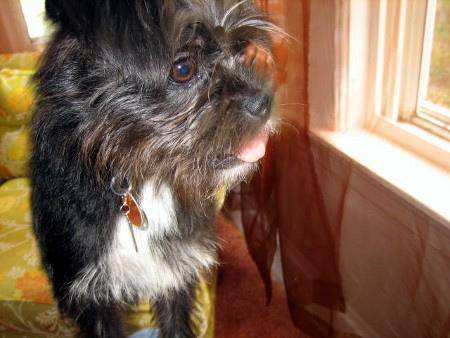

In [ ]:
dataset = load_dataset("imagefolder", data_dir="/content/data/train_valid_test")
dataset["train"][0]["image"]

In [ ]:
type(dataset["train"][0]["image"])

PIL.JpegImagePlugin.JpegImageFile

In [ ]:
img=dataset["train"][0]["image"]
labels = dataset['train'].features['label']
labels

ClassLabel(num_classes=121, names=['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog', 'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound', 'bluetick', 'border_collie', 'border_terrier', 'borzoi', 'boston_bull', 'bouvier_des_flandres', 'boxer', 'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff', 'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo', 'doberman', 'english_foxhound', 'english_setter', 'english_springer', 'entlebucher', 'eskimo_dog', 'flat-coated_retriever', 'french_bulldog', 'german_shepherd', 'german_short-haired_pointer', 'giant_schnauzer', 'golden_retriever', 'gordon_setter', 'great_dane', 'great_pyrenees', 'greater_swiss_mountain_dog', 'groenendael', 'ibizan_hound', 'iri

In [ ]:
id2label = {id:label for id, label in enumerate(dataset['train'].features['label'].names)}
label2id = {label:id for id,label in id2label.items()}

# Feature Extraction

In [ ]:
model_name_or_path = 'facebook/deit-tiny-distilled-patch16-224'
feature_extractor = DeiTFeatureExtractor.from_pretrained(model_name_or_path)

In [ ]:
feature_extractor

DeiTFeatureExtractor {
  "crop_size": 224,
  "do_center_crop": true,
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "DeiTFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "size": 224
}

In [ ]:
transform_train = torchvision.transforms.Compose(
    [# Randomly crop the image to obtain an image with an area of 0.08 to 1 of 
     #the original area and height-to-width ratio between 3/4 and 4/3. 
     #Then, scale the image to create a new 256 x 256 image
     torchvision.transforms.RandomResizedCrop(feature_extractor.crop_size, scale=(0.08, 1.0), ratio=(3.0/4.0, 4.0/3.0)),
     torchvision.transforms.RandomHorizontalFlip(),
     # Randomly change the brightness, contrast, and saturation 
     torchvision.transforms.ColorJitter(brightness=0.4,contrast=0.4, saturation=0.4),
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
    ])

transform_test = torchvision.transforms.Compose(
    [ torchvision.transforms.CenterCrop(feature_extractor.crop_size), 
      torchvision.transforms.ToTensor(), 
      torchvision.transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
    ])

def train_transforms(examples):
    examples['pixel_values'] = [transform_train(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [transform_test(image.convert("RGB")) for image in examples['image']]
    return examples

In [ ]:
train_ds = dataset['train']
val_ds = dataset['validation']
test_ds = dataset['test']

In [ ]:
# Set the transforms
#This preprocesses each batch on the fly
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

In [ ]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=32)
eval_dataloader = DataLoader(val_ds, collate_fn=collate_fn, batch_size=32)


In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([32, 3, 224, 224])
labels torch.Size([32])


#Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeiTForImageClassification.from_pretrained(model_name_or_path,
                                                  num_labels=len(id2label),
                                                  id2label=id2label,
                                                  label2id=label2id)
model = model.to(device) #Use GPU


#HF Trainer training

In [ ]:
!rm -r deit-dogs

In [ ]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    f"deit-dogs",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    remove_unused_columns=False,
    fp16=True
)

from datasets import load_metric
import numpy as np

metric = load_metric("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels,average="micro")



import torch

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
)


trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using amp half precision backend
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 19724
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 3085


Epoch,Training Loss,Validation Loss,F1
1,1.866400,1.404278,0.717876
2,1.613200,1.104635,0.768050
3,1.387800,0.969391,0.790897
4,1.266100,0.886120,0.804972
5,1.146100,0.859822,0.811278


***** Running Evaluation *****
  Num examples = 10942
  Batch size = 32
Saving model checkpoint to deit-dogs/checkpoint-617
Configuration saved in deit-dogs/checkpoint-617/config.json
Model weights saved in deit-dogs/checkpoint-617/pytorch_model.bin
Feature extractor saved in deit-dogs/checkpoint-617/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 10942
  Batch size = 32
Saving model checkpoint to deit-dogs/checkpoint-1234
Configuration saved in deit-dogs/checkpoint-1234/config.json
Model weights saved in deit-dogs/checkpoint-1234/pytorch_model.bin
Feature extractor saved in deit-dogs/checkpoint-1234/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 10942
  Batch size = 32
Saving model checkpoint to deit-dogs/checkpoint-1851
Configuration saved in deit-dogs/checkpoint-1851/config.json
Model weights saved in deit-dogs/checkpoint-1851/pytorch_model.bin
Feature extractor saved in deit-dogs/checkpoint-1851/preprocessor_config.json
***** Runni

TrainOutput(global_step=3085, training_loss=1.4067873542080822, metrics={'train_runtime': 1330.694, 'train_samples_per_second': 74.112, 'train_steps_per_second': 2.318, 'total_flos': 4.941763632071885e+17, 'train_loss': 1.4067873542080822, 'epoch': 5.0})